In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import StratifiedKFold,KFold

img_row = 224
img_col = 224
batch_size=18

subject='hiaa2'
main_path=os.path.join("E:\\kaggle_imgs",subject)
img_path=os.path.join(main_path,"img")
data_path=os.path.join(main_path,"data")
saved_path=os.path.join(main_path,"saved_models")
paths=[main_path, img_path,saved_path,data_path]
for fp in paths:
    print(fp)
    if not os.path.exists(fp):        
        os.mkdir(fp)
file_path=os.path.join(saved_path,"epoch_ 0_acc_98.63.pth")
file_best=os.path.join(saved_path,"epoch_ 0_acc_98.63.pth")

train_img_pkl=os.path.join(data_path,"train.csv")
test_img_pkl=os.path.join(data_path,"test_imgs.npy")
train_info_pkl=os.path.join(data_path,"df_train_pickle.csv")

num_classes=4

E:\kaggle_imgs\hiaa2
E:\kaggle_imgs\hiaa2\img
E:\kaggle_imgs\hiaa2\saved_models
E:\kaggle_imgs\hiaa2\data


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

## Make data file

In [3]:
def read_train_info():
    fp=train_img_pkl
    if False and os.path.exists(fp):
        try:
            print('loading train data from csv', flush=True)
            df_train=pd.read_csv(fp)
            print('complete!', flush=True)
        except EOFError:
            print('EOFError raised.', flush=True)
    else:
        files=os.listdir(os.path.join(img_path,"train"))
        df_train=pd.DataFrame({"image_name":files})
        df_train=df_train[~df_train.image_name.str.contains('mask')].reset_index(drop=True)
        df_train["id"]=df_train["image_name"].apply(lambda x : int(x.split('.')[0]))
        df_train["mask_name"]=df_train["id"].apply(lambda x : str(x)+"_mask.png")
        kf=KFold(n_splits=5,random_state=22)        
        df_train["fold"]=-1
        X=df_train.id
        for i,(train_idx,valid_idx) in enumerate(kf.split(X)):
            df_train.loc[valid_idx,"fold"]=i
        df_train.to_csv(fp,index=False)
        
    return df_train
    
df_train=read_train_info()    

C:\Users\ipofri-desktop\anaconda3\envs\tch\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


## Augmentation

In [4]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, Rotate, Cutout, VerticalFlip, Normalize
)
from albumentations.pytorch import ToTensor

from torchvision import transforms


In [5]:
train_transforms = transforms.Compose([
                                  transforms.ToTensor()])
valid_transforms = transforms.Compose([
                                  transforms.ToTensor()])

In [6]:
# train_transforms= Compose([
# #     Rotate(15),
# #     OneOf([
# #         IAAAdditiveGaussianNoise(),
# #         GaussNoise(),
# #     ], p=0.2),
# #     OneOf([
# #         MotionBlur(p=0.2),
# #         MedianBlur(blur_limit=3, p=0.1),
# #         Blur(blur_limit=3, p=0.1),
# #     ], p=0.2),
# #     ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
# #     OneOf([
# #         OpticalDistortion(p=0.3),
# #         GridDistortion(p=0.1),
# #         IAAPiecewiseAffine(p=0.3),
# #     ], p=0.2),
# #     OneOf([
# #         CLAHE(clip_limit=2),
# #         IAASharpen(),
# #         IAAEmboss(),
# #         RandomBrightnessContrast(),
# #     ], p=0.3),
# #     HueSaturationValue(p=0.3),
# #     Normalize(),
#     ToTensor()
# ])
# valid_transforms=Compose([
# #     Normalize(),
#     ToTensor()
# ])

## Dataset

In [7]:
from torch.utils.data import Dataset
from PIL import Image

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

class PlantDataset(Dataset):
    def __init__(self, df, tr=None,subset="train"):
        self.df = df
        self.tr=tr
        self.subset=subset
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        image_name=self.df.iloc[idx].image_name
        img = Image.open(img_path+"/train/"+image_name)
        img=np.uint8(img)
        img=img.reshape(img_row,img_col,1)
        img=np.repeat(img,3,2)
        #img=self.tr(image=img)["image"]
        img = self.tr(img)
            
        mask=np.zeros_like(img)
        if self.subset=="train":
            mask_name=self.df.iloc[idx].mask_name
            mask = Image.open(img_path+"/train/"+mask_name)
            mask =np.uint8(mask)
            #mask=self.tr(image=mask)["image"]
            mask = self.tr(mask)

        return img, mask

## transforms and normalization

In [8]:
def get_images_by_fold(fold):
    sel=fold
    trn_fold=[i for i in range(5) if i not in [sel]]
    val_fold=[i for i in range(5) if i in [sel]]
    trn_idx=df_train[df_train.fold.isin(trn_fold)].index
    val_idx=df_train[df_train.fold.isin(val_fold)].index
    trainset = PlantDataset(df=df_train.loc[trn_idx],
                           tr=train_transforms)
    validset =PlantDataset(df=df_train.loc[val_idx],
                          tr=valid_transforms)

    train_loader = torch.utils.data.DataLoader(trainset,
                                              batch_size=batch_size,
                                              shuffle=True, num_workers=0)
    valid_loader = torch.utils.data.DataLoader(validset,
                                              batch_size=batch_size,
                                              shuffle=False, num_workers=0)
    return train_loader,valid_loader

(224, 224)


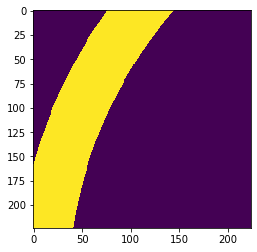

In [9]:
## test       
image_name="10014_mask.png"
img = Image.open(img_path+"/train/"+image_name)
img=np.uint8(img)
plt.imshow(img)
print(img.shape)

In [10]:
train_loader,valid_loader=get_images_by_fold(0)

In [11]:
for img,mask in train_loader:
    break

..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [13]:
mask[0].size(),img[0].size()


(torch.Size([1, 224, 224]), torch.Size([3, 224, 224]))

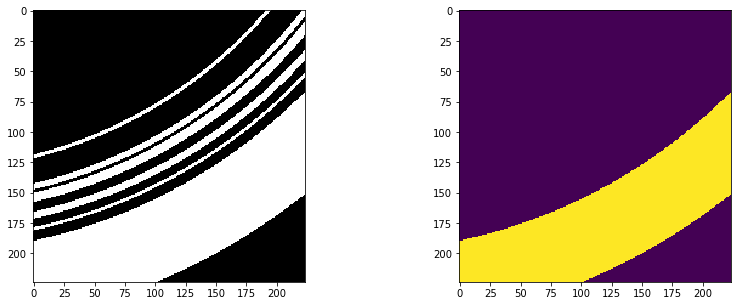

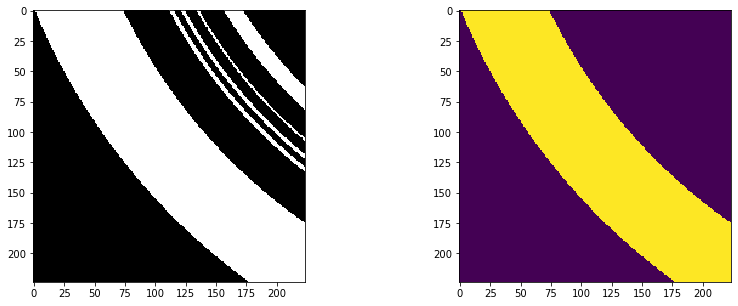

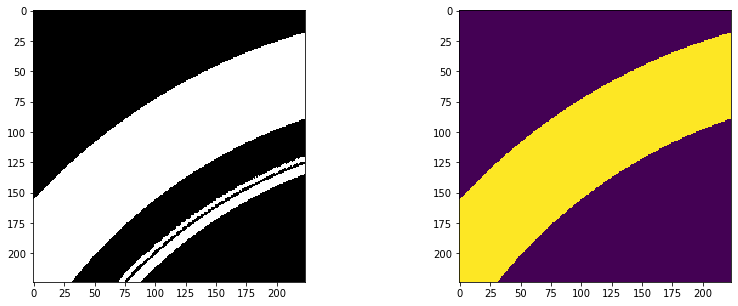

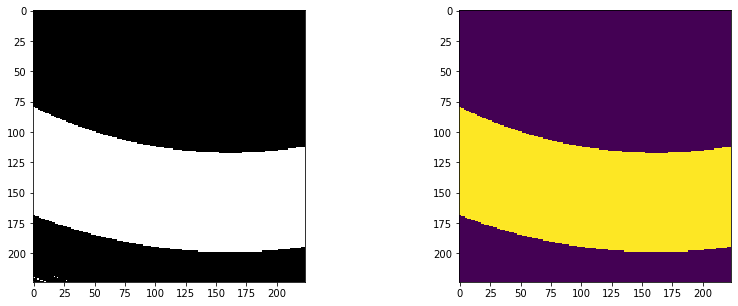

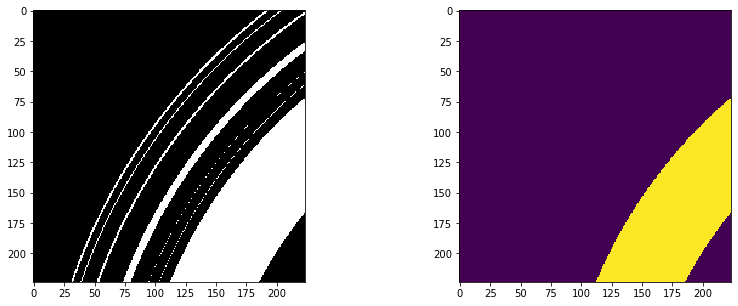

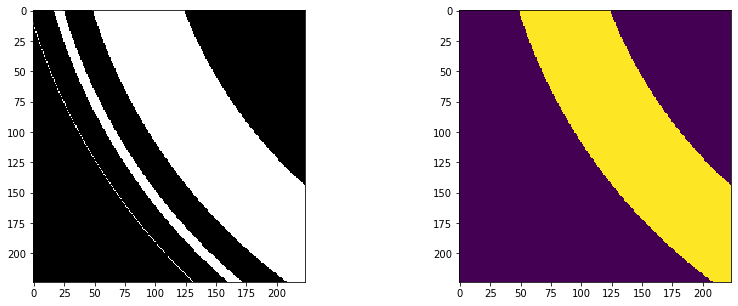

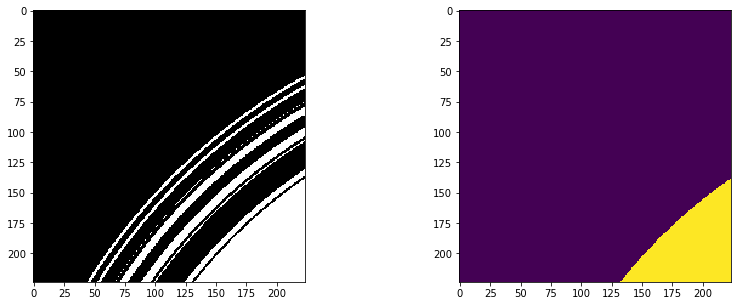

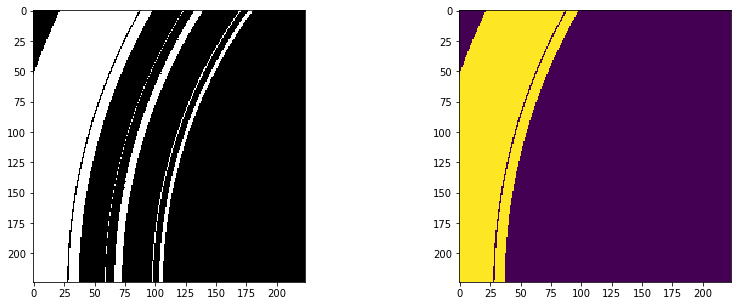

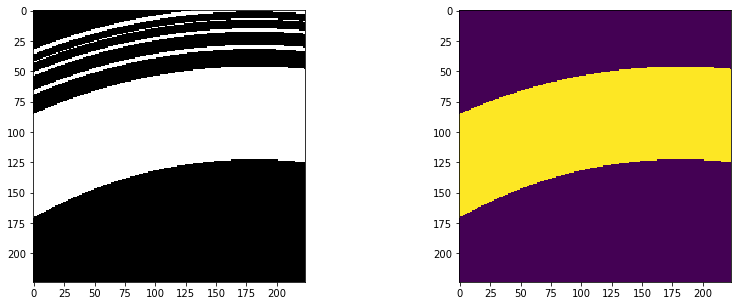

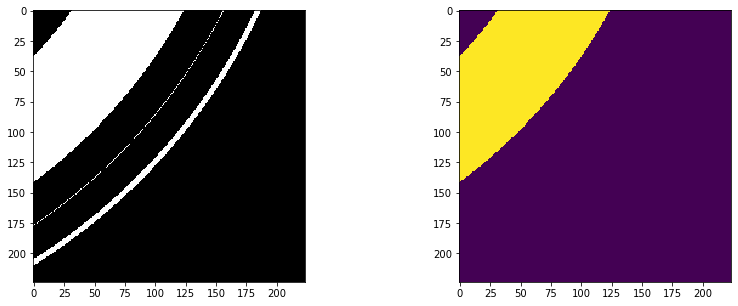

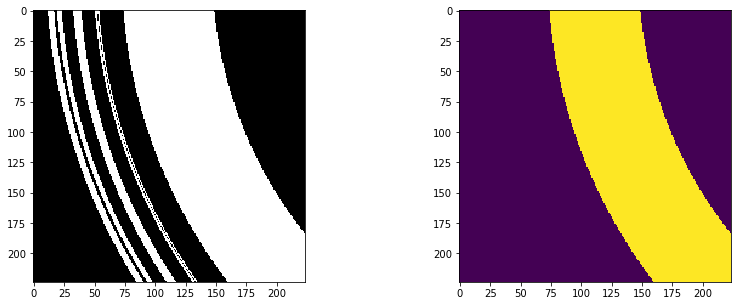

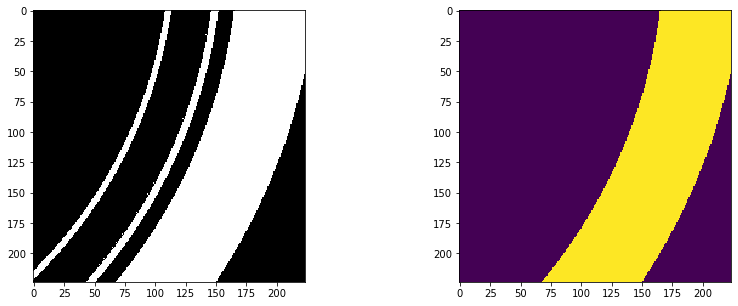

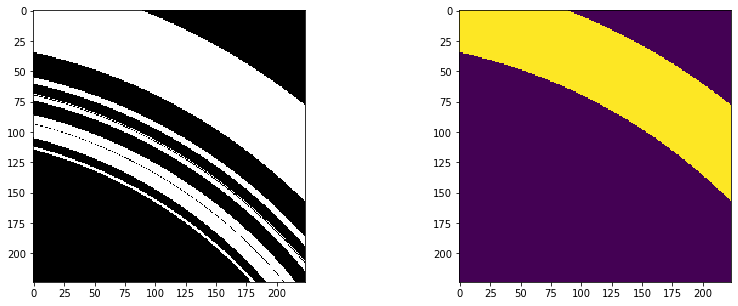

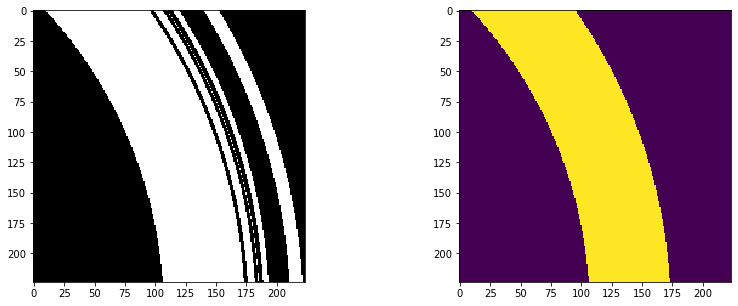

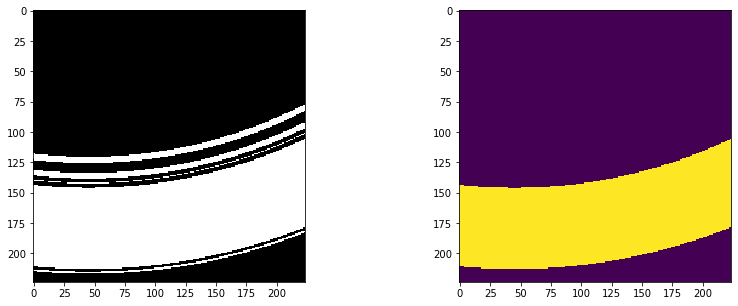

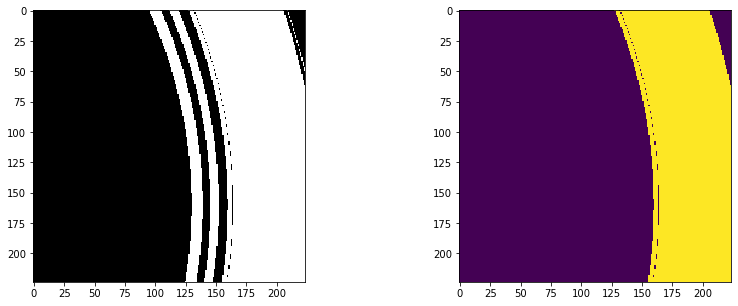

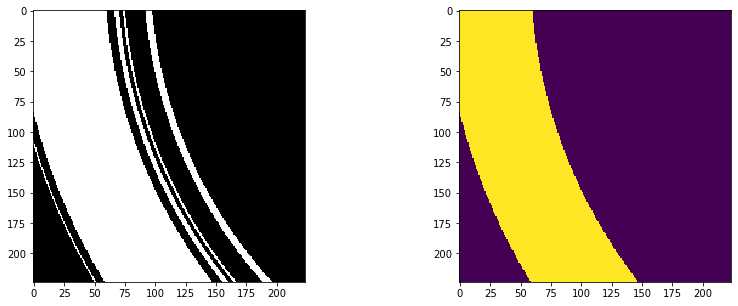

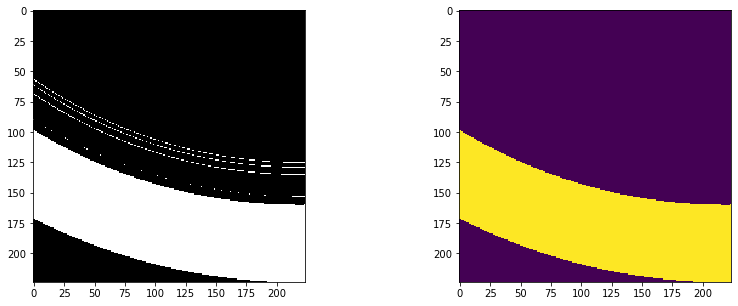

In [14]:
for i in range(batch_size):
    f,ax=plt.subplots(1,2,figsize=(14,5))
    ax[0].imshow(img[i].permute(1,2,0)*255)
    ax[1].imshow(mask[i].permute(1,2,0).squeeze())
    plt.show()

## Model

In [15]:
import torch
import torch.nn as nn
from torchvision import models

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetUNet(n_class=6)
model = model.to(device)

# check keras-like model summary using torchsummary
from torchsummary import summary
summary(model, input_size=(3, 224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 112, 112]           9,408
            Conv2d-6         [-1, 64, 112, 112]           9,408
       BatchNorm2d-7         [-1, 64, 112, 112]             128
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
             ReLU-10         [-1, 64, 112, 112]               0
        MaxPool2d-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]          36,864
           Conv2d-14           [-1, 64,

## define the main training loop

In [17]:
from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            my_loader= train_loader if phase=="train" else valid_loader
            for inputs, labels in my_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Training

In [18]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 1
model = ResNetUNet(num_class).to(device)

# freeze backbone layers
#for l in model.base_layers:
#    for param in l.parameters():
#        param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=60)

cuda:0
Epoch 0/59
----------
LR 0.0001


C:\Users\ipofri-desktop\anaconda3\envs\tch\lib\site-packages\torch\optim\lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
C:\Users\ipofri-desktop\anaconda3\envs\tch\lib\site-packages\torch\nn\functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train: bce: 0.099671, dice: 0.105245, loss: 0.102458
val: bce: 0.017060, dice: 0.019132, loss: 0.018096
saving best model
1m 14s
Epoch 1/59
----------
LR 0.0001
train: bce: 0.013713, dice: 0.013510, loss: 0.013611
val: bce: 0.010545, dice: 0.010223, loss: 0.010384
saving best model
1m 16s
Epoch 2/59
----------
LR 0.0001
train: bce: 0.010094, dice: 0.009571, loss: 0.009832
val: bce: 0.008494, dice: 0.007714, loss: 0.008104
saving best model
1m 14s
Epoch 3/59
----------
LR 0.0001
train: bce: 0.008735, dice: 0.007943, loss: 0.008339
val: bce: 0.008536, dice: 0.006889, loss: 0.007712
saving best model
1m 15s
Epoch 4/59
----------
LR 0.0001
train: bce: 0.006759, dice: 0.006524, loss: 0.006642
val: bce: 0.006170, dice: 0.005863, loss: 0.006017
saving best model
1m 14s
Epoch 5/59
----------
LR 0.0001
train: bce: 0.005656, dice: 0.005548, loss: 0.005602
val: bce: 0.006033, dice: 0.004543, loss: 0.005288
saving best model
1m 14s
Epoch 6/59
----------
LR 0.0001
train: bce: 0.004894, dice: 0.0046

KeyboardInterrupt: 

## Use the trained model

In [65]:
import math
model.eval()

# get the first batch
for i,(inputs,labels) in enumerate(valid_loader):
    inputs=inputs.to(device)
    labels=labels.to(device)

    #predict
    pred=model(inputs)
    #The loss fuctions include the sigmoid function.
    pred=F.sigmoid(pred)
    pred=pred.data.cpu().numpy()
    print(pred.shape)

    inputs=inputs.to("cpu")
    labels=labels.to("cpu")
    if i==11:
        break


(18, 1, 224, 224)
(18, 1, 224, 224)
(18, 1, 224, 224)
(18, 1, 224, 224)
(18, 1, 224, 224)
(18, 1, 224, 224)
(18, 1, 224, 224)
(18, 1, 224, 224)
(18, 1, 224, 224)
(18, 1, 224, 224)
(18, 1, 224, 224)
(18, 1, 224, 224)


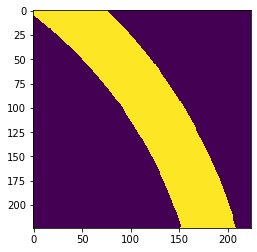

In [71]:
img1=np.uint8(pred[0].squeeze()>0.001)
plt.imshow(img1)

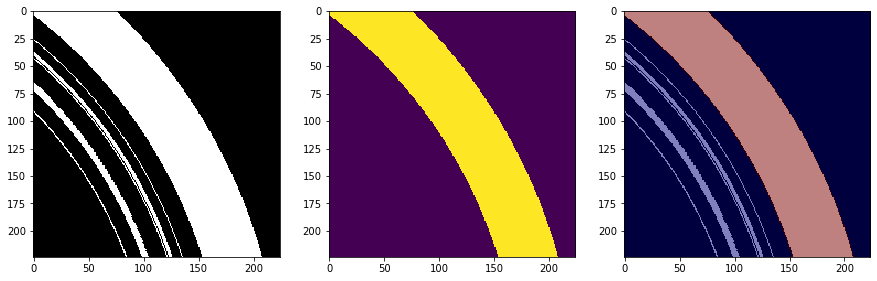

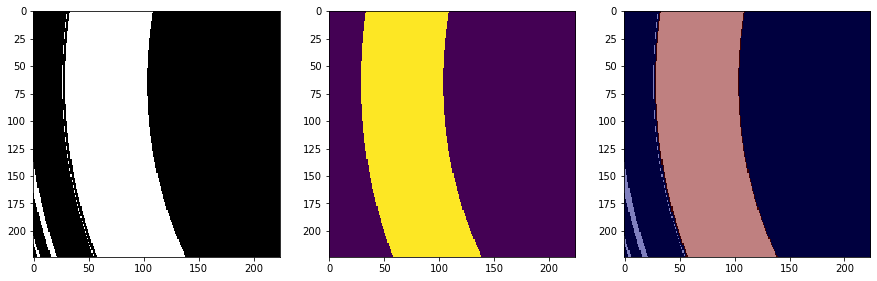

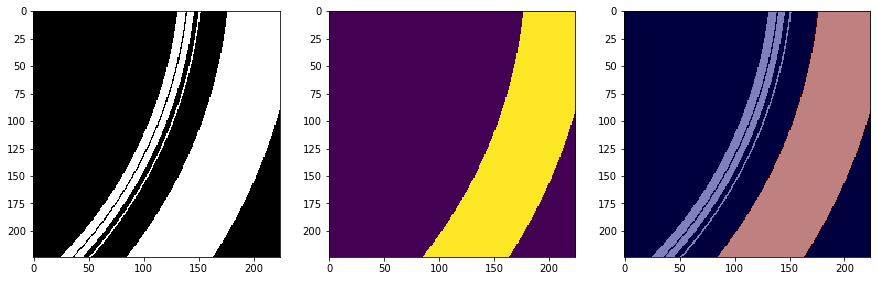

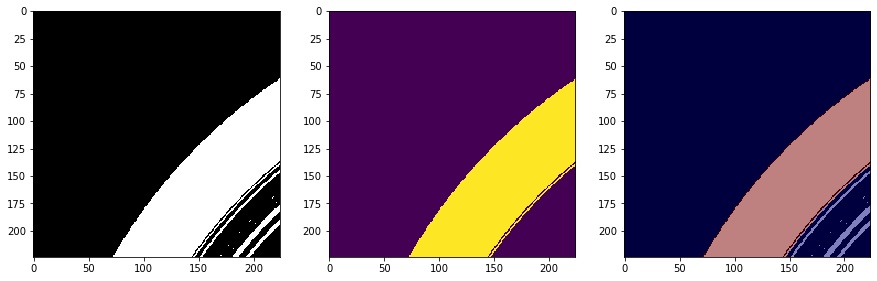

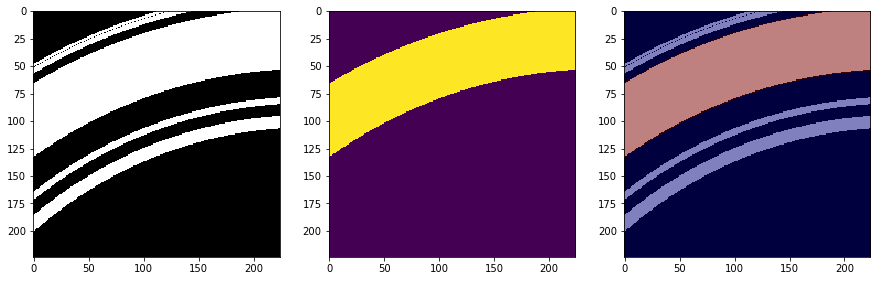

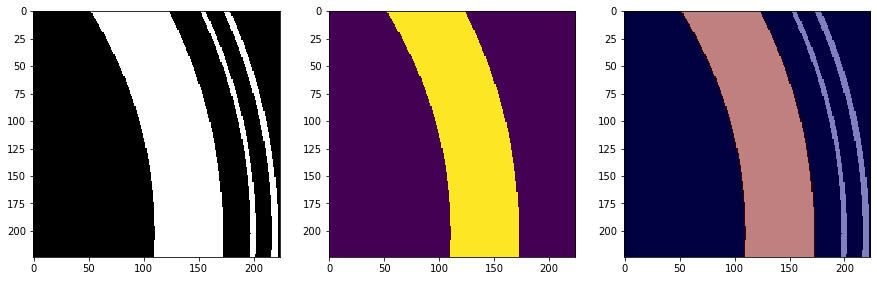

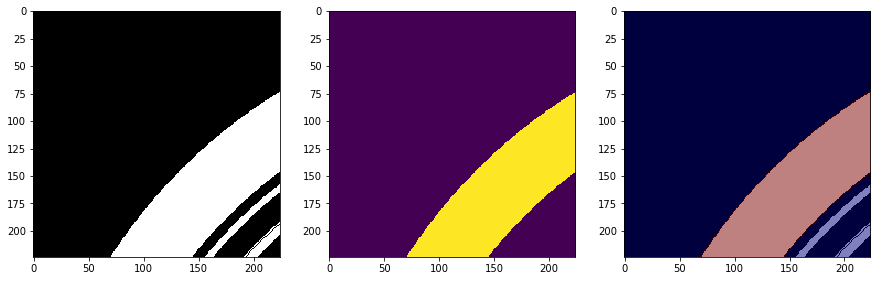

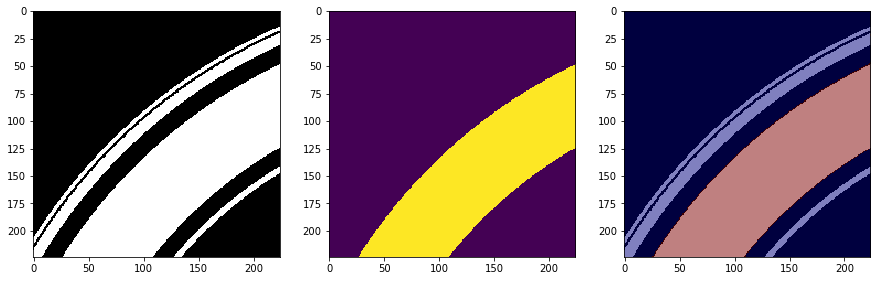

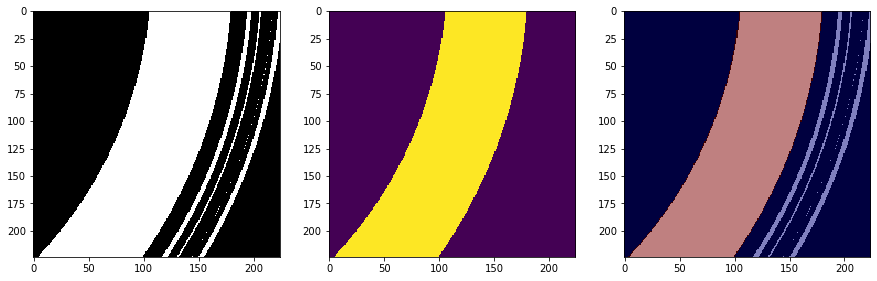

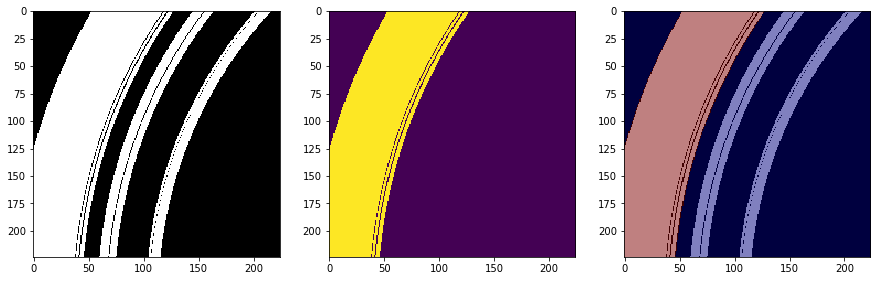

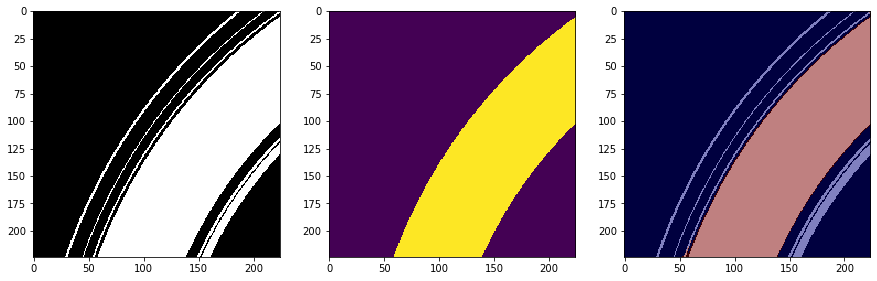

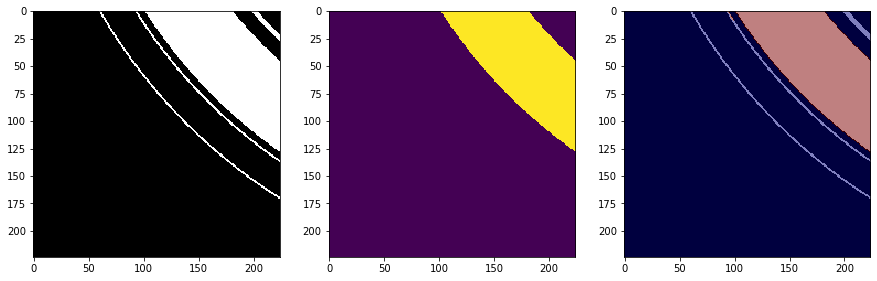

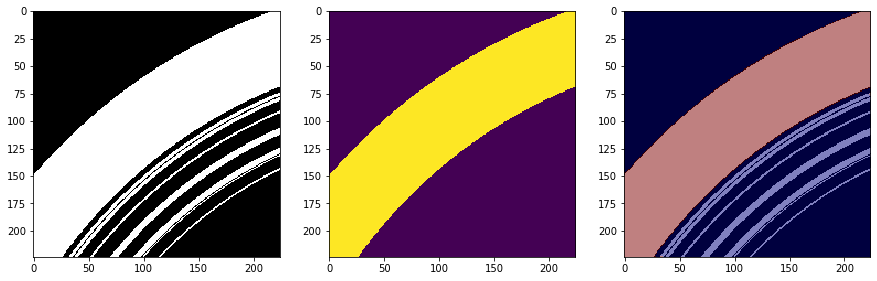

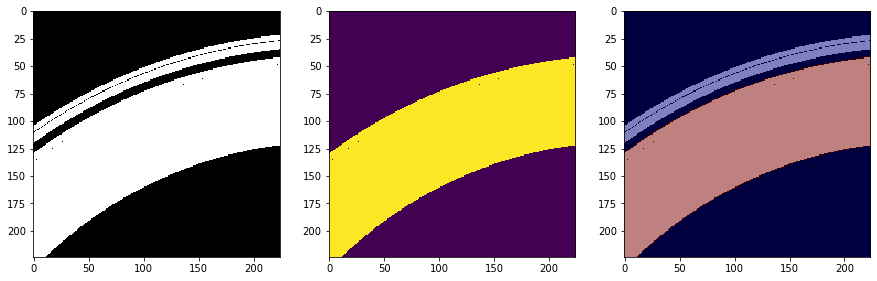

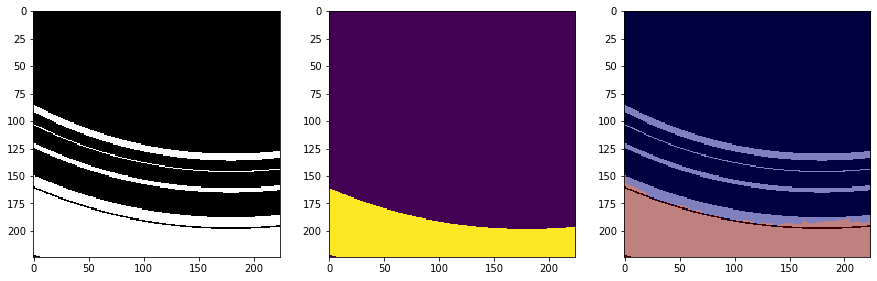

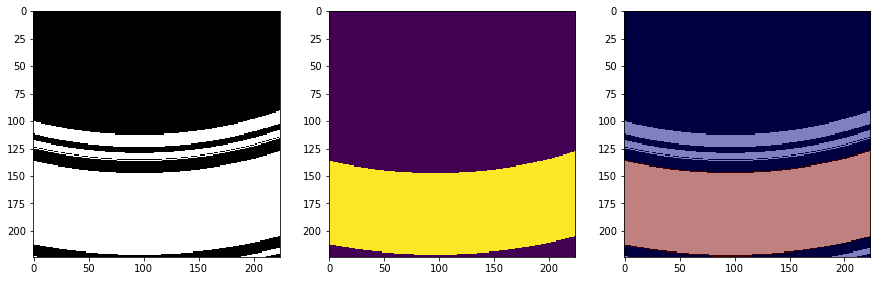

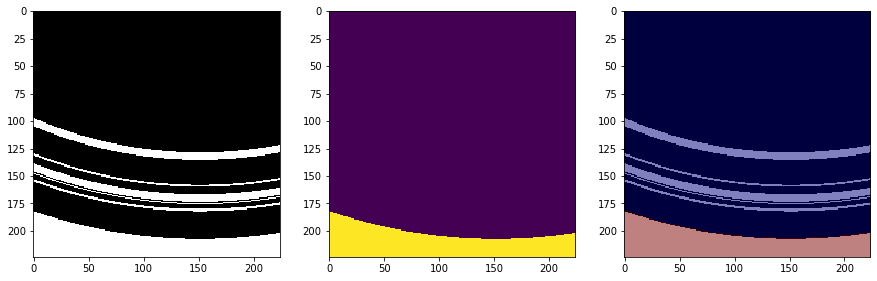

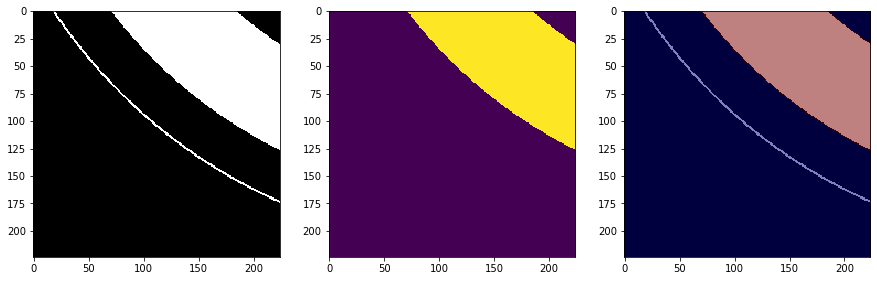

In [73]:
for i in range(batch_size):
    f,ax=plt.subplots(1,3,figsize=(15,7))
    ax[0].imshow(inputs[i].permute(1,2,0)*255)
    ax[1].imshow(labels[i].permute(1,2,0).squeeze())
    img1=np.uint8(pred[i].squeeze()>0.001)
    ax[2].imshow(inputs[i].permute(1,2,0)*255)
    ax[2].imshow(img1, cmap="jet",alpha=0.5)
    plt.show()

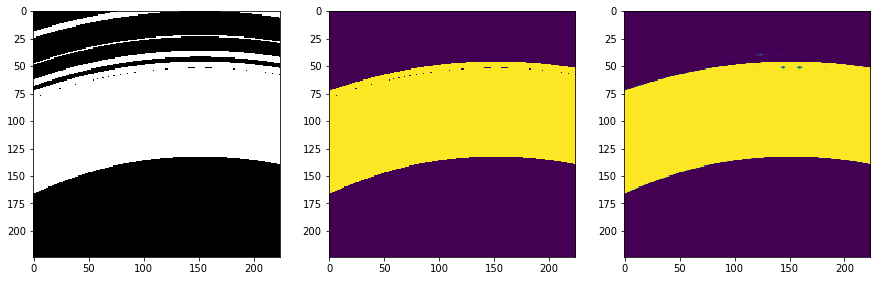

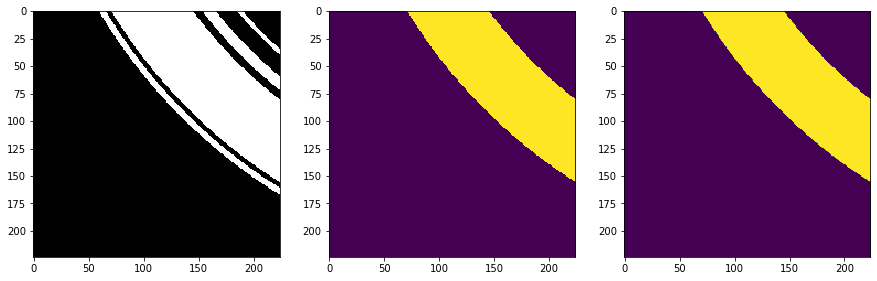

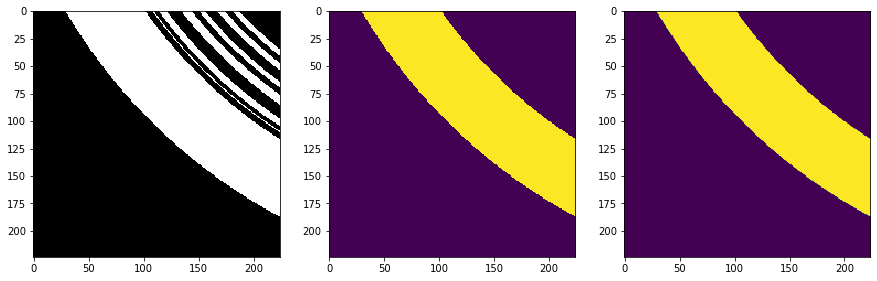

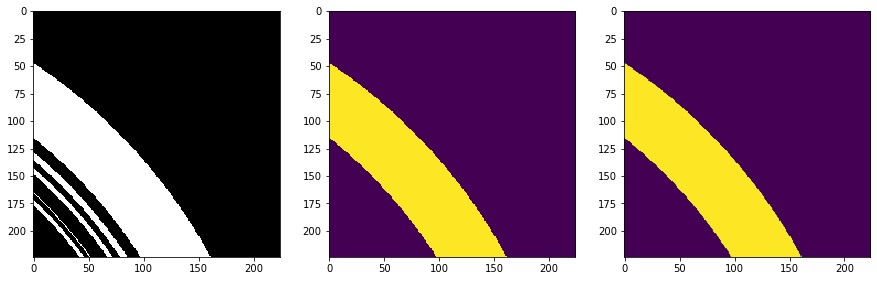

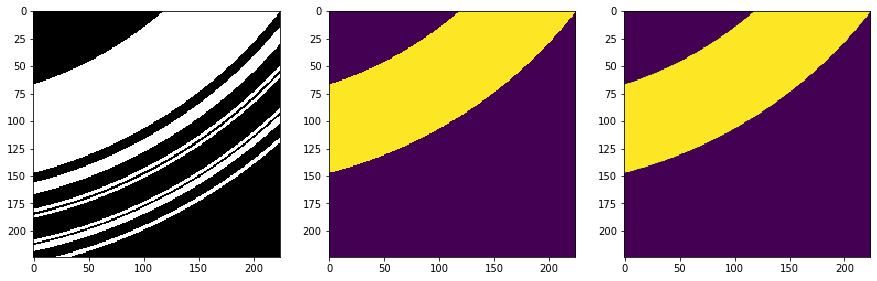

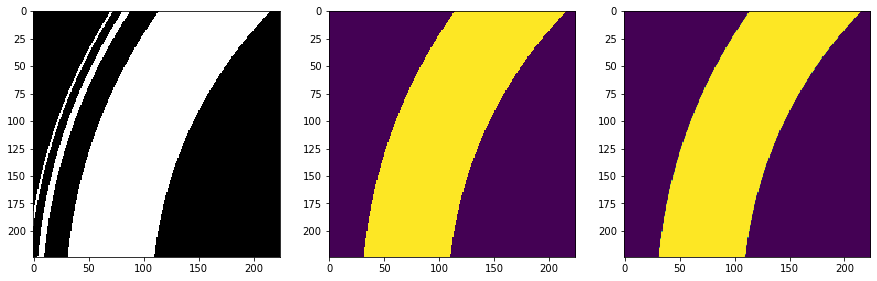

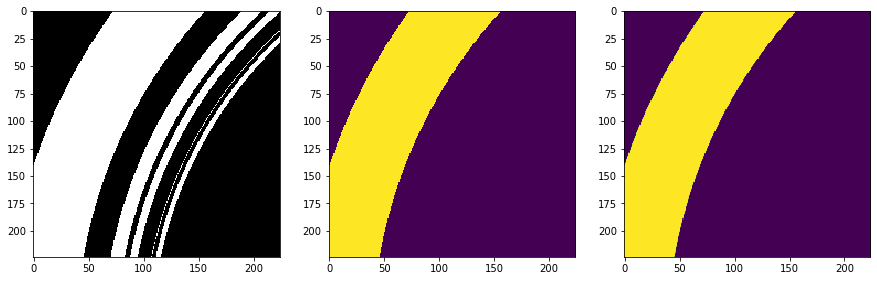

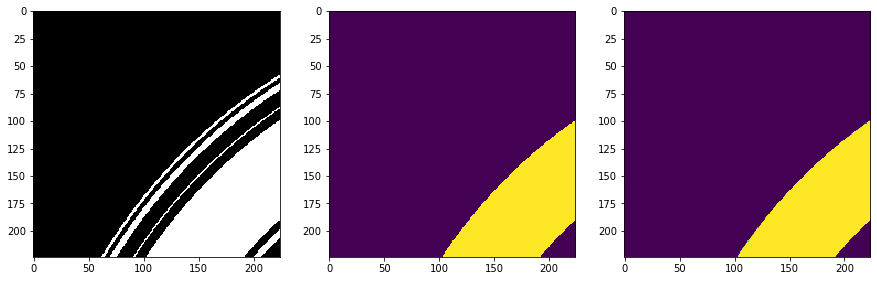

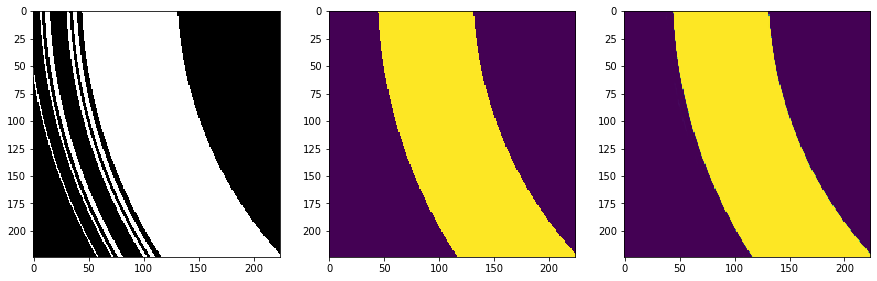

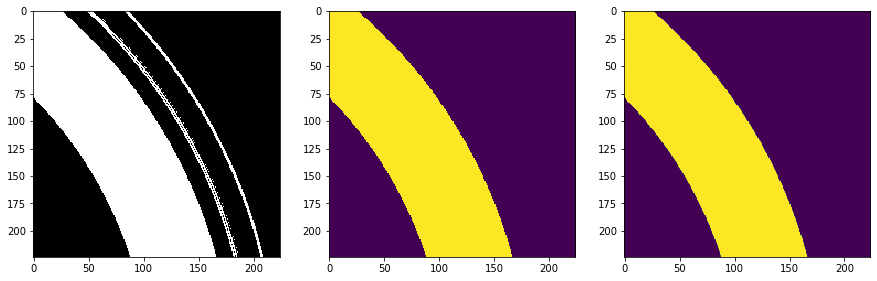

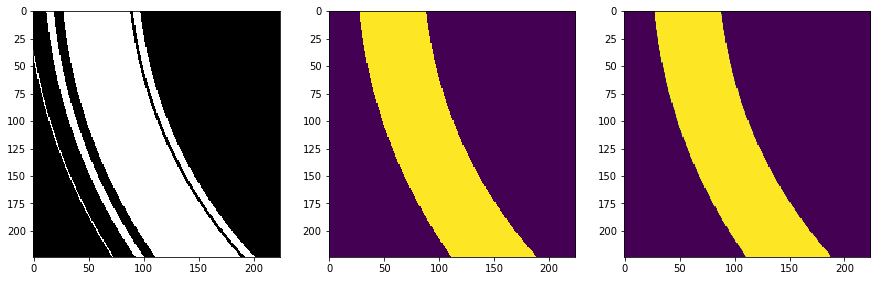

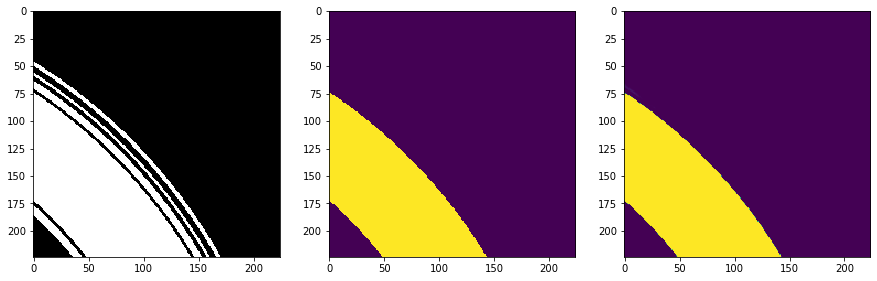

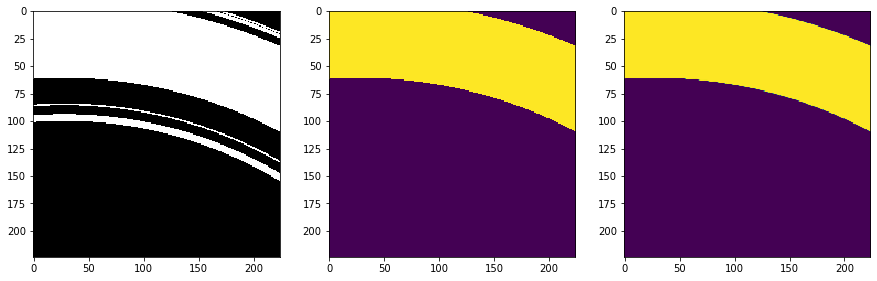

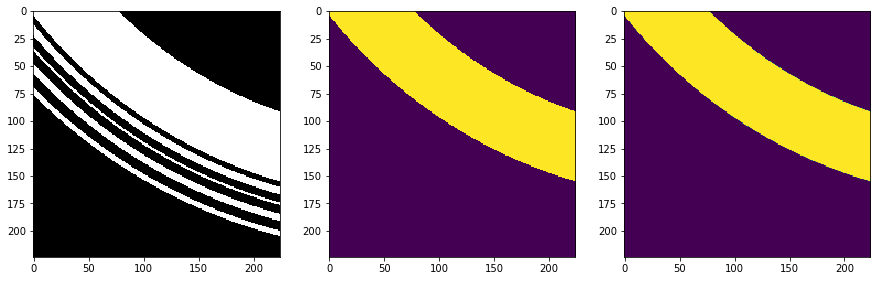

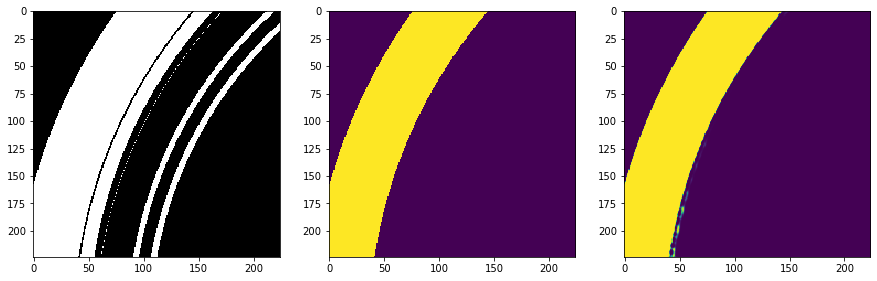

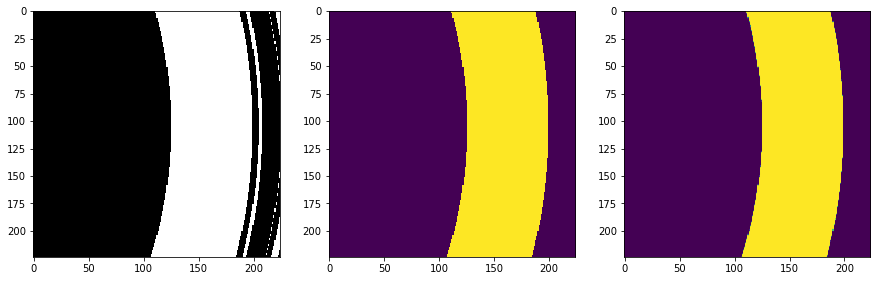

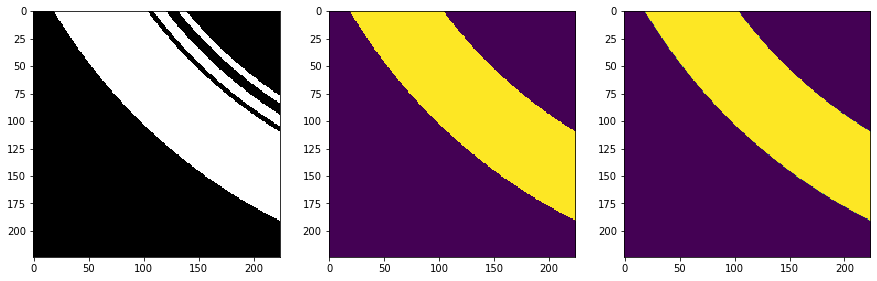

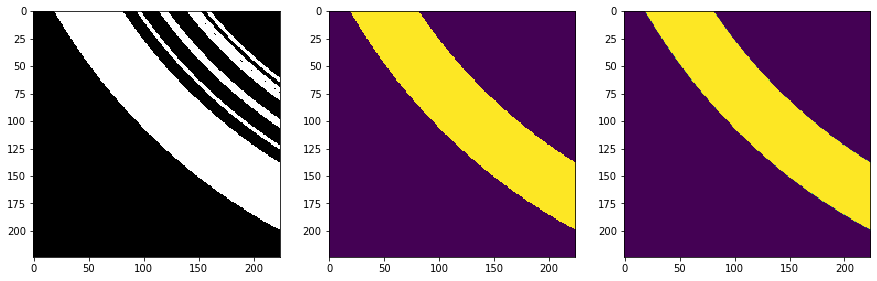

In [25]:
for i in range(batch_size):
    f,ax=plt.subplots(1,3,figsize=(15,7))
    ax[0].imshow(inputs[i].permute(1,2,0)*255)
    ax[1].imshow(labels[i].permute(1,2,0).squeeze())
    ax[2].imshow(pred[i].squeeze())
    plt.show()

In [52]:
def mask_color_img(img, mask, color=[0, 255, 255], alpha=0.3):
    '''
    img: cv2 image
    mask: bool or np.where
    color: BGR triplet [_, _, _]. Default: [0, 255, 255] is yellow.
    alpha: float [0, 1]. 

    Ref: http://www.pyimagesearch.com/2016/03/07/transparent-overlays-with-opencv/
    '''
    out = img.copy()
    img_layer = img.copy()
    img_layer[mask] = color
    out = cv2.addWeighted(img_layer, alpha, out, 1 - alpha, 0, out)
    return(out)